In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import higherOrderKME
# from higherOrderKME import sigkernel
import Path_Char
from Path_Char.path_characteristic_function import char_func_path
from Path_Char.model import LSTMGenerator, UnitaryLSTMGenerator
from Path_Char.utils import AddTime
from torch.utils.data import DataLoader
import ml_collections
import seaborn as sns
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sns.set()
torch.manual_seed(0)
device = 'cuda'

In [8]:
config = {'G_input_dim': 2,
          'G_hidden_dim': 32,
          'G_num_layers': 2,
          'G_output_dim': 3}
config = ml_collections.ConfigDict(config)

In [9]:
torch.manual_seed(0)
np.random.seed(0)
# number of path coordinates and number of time steps
D, L = 1, 3 

# experimental setup
repeats, n_samples, n, lambda_ = 100, 500, 5*1e5, 1e-5

# to store the sample paths from X_n and X
X = np.zeros((repeats, n_samples, 2, L, D)) 
X_n = np.zeros((repeats, n_samples, 2, L, D))   

# sample from X_n 
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
omega_2 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X_n[:, :, :, 1, 0] = omega_1 * 1./n
X_n[:, :, :, 2, 0] = 0.1 * omega_1

# sample from X
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X[:, :, :, 2, 0] = 0.1 * omega_1

X = torch.tensor(X.reshape([-1, L, D]))
X_n = torch.tensor(X_n.reshape([-1, L, D]))

X = AddTime(X).to(torch.float)
X_n = AddTime(X_n).to(torch.float)

In [10]:
lie_degree_1 = 3
num_samples_1 = 1
input_size = 1
add_time = True

pcf_level_1 = char_func_path(num_samples=num_samples_1, 
                              hidden_size=lie_degree_1, 
                              input_dim=input_size, 
                              add_time=add_time, 
                              include_initial = False,
                              return_sequence=False)
pcf_level_1.to(device)

char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)

In [11]:
with torch.no_grad():
    dev_X = pcf_level_1.unitary_development(X.to(device)).repeat([1, L, 1, 1])
    dev_X_n = pcf_level_1.unitary_development(X_n.to(device)).repeat([1, L, 1, 1])
    
train_X_dl = DataLoader(X, 128, shuffle=True)
train_X_dev_dl = DataLoader(dev_X, 128, shuffle=True)

train_X_n_dl = DataLoader(X_n, 128, shuffle=True)
train_X_n_dev_dl = DataLoader(dev_X_n, 128, shuffle=True)

In [12]:
next(iter(train_X_dev_dl)).shape

torch.Size([128, 3, 3, 3])

In [13]:
regressor_for_X = UnitaryLSTMGenerator(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
regressor_for_X.to(device)

regressor_for_Y = UnitaryLSTMGenerator(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
regressor_for_Y.to(device)

UnitaryLSTMGenerator(
  (rnn): LSTM(2, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=18, bias=False)
  (activation): Tanh()
)

In [14]:
torch.norm(dev_X[0] - dev_X_n[0], dim=(1,2))

tensor([0.3180, 0.3180, 0.3180], device='cuda:0')

In [15]:
def train_regressor(regressor, iterations, X_dl, Y_dl):
    best_loss = 10000.
    regressor_optimizer = torch.optim.Adam(regressor.parameters(), betas=(0, 0.9), lr=0.002)
    regressor.train()
    for i in tqdm(range(iterations)):
        regressor_optimizer.zero_grad()
        batch_X = next(iter(X_dl))
        batch_X_dev = next(iter(Y_dl))
        reg_dev = regressor(batch_X, device)
    #     print(batch_Y.shape, reg_dev.shape)
        regressor_loss = torch.norm(reg_dev - batch_X_dev)
        if regressor_loss < best_loss:
            print("Loss updated: {}".format(regressor_loss), " at iteration {}".format(i))
#             with torch.no_grad():
#                 print(torch.norm(reg_dev - batch_X_dev, dim = [2,3]).mean(0))
            best_loss = regressor_loss
            trained_regressor = regressor

        regressor_loss.backward()
        regressor_optimizer.step()
    
    return trained_regressor

In [16]:
trained_regressor_X = train_regressor(regressor_for_X, 10000, train_X_dl, train_X_dev_dl)
trained_regressor_Y = train_regressor(regressor_for_Y, 10000, train_X_n_dl, train_X_n_dev_dl)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss updated: 28.979656219482422  at iteration 0
Loss updated: 27.9333553314209  at iteration 1
Loss updated: 26.91461944580078  at iteration 2
Loss updated: 25.873287200927734  at iteration 3
Loss updated: 24.83772850036621  at iteration 4
Loss updated: 23.672914505004883  at iteration 5
Loss updated: 22.62421417236328  at iteration 6
Loss updated: 21.493362426757812  at iteration 7
Loss updated: 20.311201095581055  at iteration 8
Loss updated: 19.084177017211914  at iteration 9
Loss updated: 17.959156036376953  at iteration 10
Loss updated: 17.06922149658203  at iteration 11
Loss updated: 16.00150489807129  at iteration 12
Loss updated: 15.199947357177734  at iteration 13
Loss updated: 14.422430038452148  at iteration 14
Loss updated: 13.754927635192871  at iteration 15
Loss updated: 13.232853889465332  at iteration 16
Loss updated: 12.690415382385254  at iteration 17
Loss updated: 12.456701278686523  at iteration 18
Loss updated: 12.067184448242188  at iteration 19
Loss updated: 11.

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss updated: 30.042631149291992  at iteration 0
Loss updated: 29.250598907470703  at iteration 1
Loss updated: 28.209444046020508  at iteration 2
Loss updated: 27.311471939086914  at iteration 3
Loss updated: 26.45010757446289  at iteration 4
Loss updated: 25.489912033081055  at iteration 5
Loss updated: 24.50069236755371  at iteration 6
Loss updated: 23.547847747802734  at iteration 7
Loss updated: 22.34724998474121  at iteration 8
Loss updated: 21.218650817871094  at iteration 9
Loss updated: 20.263059616088867  at iteration 10
Loss updated: 19.061420440673828  at iteration 11
Loss updated: 18.018659591674805  at iteration 12
Loss updated: 16.884349822998047  at iteration 13
Loss updated: 15.822080612182617  at iteration 14
Loss updated: 15.149462699890137  at iteration 15
Loss updated: 14.25119686126709  at iteration 16
Loss updated: 13.767148971557617  at iteration 17
Loss updated: 13.201032638549805  at iteration 18
Loss updated: 12.854157447814941  at iteration 19
Loss updated: 

In [14]:
trained_regressor_X = regressor_for_X
trained_regressor_Y = regressor_for_Y

In [15]:
with torch.no_grad():
    exp_dev_X = trained_regressor_X(next(iter(train_X_dl)), device)
    exp_dev_Y = trained_regressor_Y(next(iter(train_X_n_dl)), device)

In [17]:
class expected_dev():
    
    def __init__(self, regressor_X, regressor_X_n, lie_degree_1, lie_degree_2, add_time = True, device = 'cuda'):
        super(expected_dev, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.device = device
        self.regressor_X = regressor_X
        self.regressor_X_n = regressor_X_n
        self.regressor_X.to(device)
        self.regressor_X_n.to(device)
        
        self.X_case_1 = torch.tensor([[[0.3333, 0.0000],
                                       [0.6667, 0.0000],
                                       [1.0000, 0.1000]]]).to(torch.float).to(device)
        self.X_case_2 = torch.tensor([[[0.3333, 0.0000],
                                       [0.6667, 0.0000],
                                       [1.0000, -0.1000]]]).to(torch.float).to(device)
        self.X_n_case_1 = torch.tensor([[[ 3.3333e-01, 0.0000e+00],
                                         [ 6.6667e-01, 2.0000e-06],
                                         [ 1.0000e+00, 1.0000e-01]]]).to(torch.float).to(device)
        self.X_n_case_2 = torch.tensor([[[ 3.3333e-01, 0.0000e+00],
                                         [ 6.6667e-01, -2.0000e-06],
                                         [ 1.0000e+00, -1.0000e-01]]]).to(torch.float).to(device)

        
        self.lie_degree_1 = lie_degree_1
        self.add_time = add_time
        self.num_samples_2 = 10
        self.lie_degree_2 = 5
        self.pcf_level_2 = char_func_path(num_samples=self.num_samples_2, 
                                      hidden_size=self.lie_degree_2, 
                                      input_dim=2*self.lie_degree_1**2, 
                                      add_time=add_time, 
                                      include_initial = False,
                                      return_sequence=False)
        self.pcf_level_2.to(device)
        
        
    def level_1_exp_dev(self):
        if self.add_time:
            dev_X_case_1 = self.pcf_level_1.unitary_development(self.X_case_1).squeeze()
            dev_X_case_2 = self.pcf_level_1.unitary_development(self.X_case_2).squeeze()
            dev_X_n_case_1 = self.pcf_level_1.unitary_development(self.X_n_case_1).squeeze()
            dev_X_n_case_2 = self.pcf_level_1.unitary_development(self.X_n_case_2).squeeze()
        else:
            dev_X_case_1 = self.pcf_level_1.unitary_development(self.X_case_1[:,:,1:]).squeeze()
            dev_X_case_2 = self.pcf_level_1.unitary_development(self.X_case_2[:,:,1:]).squeeze()
            dev_X_n_case_1 = self.pcf_level_1.unitary_development(self.X_n_case_1[:,:,1:]).squeeze()
            dev_X_n_case_2 = self.pcf_level_1.unitary_development(self.X_n_case_2[:,:,1:]).squeeze()
            
        exp_dev_X_case_1 = torch.zeros([self.X_case_1.shape[1], self.lie_degree_1 ,self.lie_degree_1]).to(self.device).to(torch.cfloat) 
        exp_dev_X_case_2 = torch.zeros([self.X_case_1.shape[1], self.lie_degree_1 ,self.lie_degree_1]).to(self.device).to(torch.cfloat) 
        exp_dev_X_n_case_1 = torch.zeros([self.X_case_1.shape[1], self.lie_degree_1 ,self.lie_degree_1]).to(self.device).to(torch.cfloat) 
        exp_dev_X_n_case_2 = torch.zeros([self.X_case_1.shape[1], self.lie_degree_1 ,self.lie_degree_1]).to(self.device).to(torch.cfloat) 
        
        exp_dev_X_case_1[0] = exp_dev_X_case_2[0] = exp_dev_X_case_1[1] = exp_dev_X_case_2[1] = (dev_X_case_1+dev_X_case_2)/2
        exp_dev_X_case_1[2] = dev_X_case_1
        exp_dev_X_case_2[2] = dev_X_case_2
        
        exp_dev_X_n_case_1[0] = exp_dev_X_n_case_1[0] = (dev_X_n_case_1+dev_X_n_case_1)/2
        exp_dev_X_n_case_1[1] = exp_dev_X_n_case_1[2] = dev_X_n_case_1
        exp_dev_X_n_case_2[1] = exp_dev_X_n_case_2[2] = dev_X_n_case_2
#         return exp_dev_X_case_1, exp_dev_X_case_2, exp_dev_X_n_case_1, exp_dev_X_n_case_2
        return exp_dev_X_case_1.reshape([-1, self.X_case_1.shape[1], self.lie_degree_1**2]), \
               exp_dev_X_case_2.reshape([-1, self.X_case_1.shape[1], self.lie_degree_1**2]), \
               exp_dev_X_n_case_1.reshape([-1, self.X_case_1.shape[1], self.lie_degree_1**2]), \
               exp_dev_X_n_case_2.reshape([-1, self.X_case_1.shape[1], self.lie_degree_1**2])
    
    def train_M(self, X_dl, X_n_dl):
        iterations = 10000
        best_loss = 0.
        
        char_2_optimizer = torch.optim.Adam(self.pcf_level_2.parameters(), betas=(0, 0.9), lr=0.002)
        
        print('start opitmize charateristics function')
        self.regressor_X.eval()
        self.regressor_X_n.eval()
        self.pcf_level_2.train()
        for i in tqdm(range(iterations)):
            
            X = next(iter(X_dl))
            X_n = next(iter(X_n_dl))
            with torch.no_grad():
                exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1**2])
                exp_dev_Y = self.regressor_X_n(X_n, self.device).reshape([-1, X_n.shape[1], self.lie_degree_1**2])
                
                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)

            char_2_optimizer.zero_grad()
            char_loss = - self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
            if -char_loss > best_loss:
                print("Loss updated: {}".format(-char_loss))
                best_loss = -char_loss
            if i%100 == 0:
                print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
            char_loss.backward()
            char_2_optimizer.step()
    
    def evaluate(self, X_dl, X_n_dl):
        self.pcf_level_2.eval()
        self.regressor_X.eval()
        self.regressor_X_n.eval()
        repeats = 100
        MMD_1 = np.zeros((repeats))
        MMD_2 = np.zeros((repeats))
        with torch.no_grad():
            for i in tqdm(range(repeats)):
                X = next(iter(X_dl))
                X_ = next(iter(X_dl))
                X_n = next(iter(X_n_dl))
                exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1**2])
                exp_dev_X_ = self.regressor_X(X_, self.device).reshape([-1, X.shape[1], self.lie_degree_1**2])
                exp_dev_Y = self.regressor_X_n(X_n, self.device).reshape([-1, X_n.shape[1], self.lie_degree_1**2])

                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)
                exp_dev_X_ = torch.cat([exp_dev_X_.real, exp_dev_X_.imag],-1)
                
                MMD_1[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_X_, Lambda=0)
                MMD_2[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
        return MMD_1, MMD_2

In [18]:
expected_devx = expected_dev(regressor_X = trained_regressor_X, regressor_X_n = trained_regressor_Y, lie_degree_1 = 3, lie_degree_2 = 5)

In [19]:
expected_devx.train_M(train_X_dl, train_X_n_dl)

start opitmize charateristics function


  0%|          | 0/10000 [00:00<?, ?it/s]

Loss updated: 4.613787677953951e-05
Iteration 0 :  loss = 4.613787677953951e-05
Loss updated: 4.6838536945870146e-05
Loss updated: 4.7792385885259137e-05
Loss updated: 4.915980025543831e-05
Loss updated: 5.036094444221817e-05
Loss updated: 5.207847061683424e-05
Loss updated: 5.286596933729015e-05
Loss updated: 5.4025527788326144e-05
Loss updated: 5.4752035794081166e-05
Loss updated: 5.584060636465438e-05
Loss updated: 5.757932740380056e-05
Loss updated: 5.905036232434213e-05
Loss updated: 6.016744373482652e-05
Loss updated: 6.168281106511131e-05
Loss updated: 6.287542782956734e-05
Loss updated: 6.442405720008537e-05
Loss updated: 6.551080878125504e-05
Loss updated: 6.75221745041199e-05
Loss updated: 6.921131716808304e-05
Loss updated: 7.055298192426562e-05
Loss updated: 7.174887286964804e-05
Loss updated: 7.369455124717206e-05
Loss updated: 7.523999374825507e-05
Loss updated: 7.751801604172215e-05
Loss updated: 7.827823719708249e-05
Loss updated: 8.032977348193526e-05
Loss updated: 8.2

Loss updated: 0.0032843705266714096
Loss updated: 0.003327923594042659
Loss updated: 0.003384676994755864
Loss updated: 0.003455519676208496
Loss updated: 0.0034845874179154634
Loss updated: 0.003675069659948349
Loss updated: 0.0038572424091398716
Loss updated: 0.004054390825331211
Loss updated: 0.004100883845239878
Loss updated: 0.0041792443953454494
Loss updated: 0.004216767847537994
Loss updated: 0.004268921911716461
Loss updated: 0.0042802090756595135
Loss updated: 0.004488867241889238
Loss updated: 0.0045151012018322945
Loss updated: 0.004619625862687826
Loss updated: 0.004635591991245747
Loss updated: 0.004838133696466684
Iteration 500 :  loss = 0.004679016303271055
Loss updated: 0.004843020346015692
Loss updated: 0.004927651025354862
Loss updated: 0.004927821457386017
Loss updated: 0.005030564032495022
Loss updated: 0.005044583231210709
Loss updated: 0.005197249352931976
Loss updated: 0.005356078501790762
Loss updated: 0.005563228856772184
Loss updated: 0.005570212844759226
Loss

Loss updated: 0.06310126930475235
Loss updated: 0.06344741582870483
Loss updated: 0.06379208713769913
Loss updated: 0.06495912373065948
Iteration 2000 :  loss = 0.06186942011117935
Loss updated: 0.06504406780004501
Loss updated: 0.06591013073921204
Loss updated: 0.06604339927434921
Loss updated: 0.06643877923488617
Loss updated: 0.06652826815843582
Loss updated: 0.06718271970748901
Loss updated: 0.06746380031108856
Loss updated: 0.0676681324839592
Loss updated: 0.06808967143297195
Loss updated: 0.06995631754398346
Iteration 2100 :  loss = 0.06755572557449341
Loss updated: 0.07244517654180527
Loss updated: 0.07398433983325958
Loss updated: 0.07572391629219055
Loss updated: 0.07660140842199326
Iteration 2200 :  loss = 0.07443556934595108
Loss updated: 0.07660748809576035
Loss updated: 0.07694731652736664
Loss updated: 0.07824563980102539
Loss updated: 0.07895201444625854
Loss updated: 0.07967109978199005
Loss updated: 0.08011502027511597
Loss updated: 0.0804104432463646
Loss updated: 0.0

Loss updated: 0.5375012755393982
Loss updated: 0.5375921130180359
Loss updated: 0.5376771688461304
Loss updated: 0.5411733984947205
Loss updated: 0.543589174747467
Iteration 6000 :  loss = 0.5265159010887146
Loss updated: 0.5545366406440735
Loss updated: 0.5620080828666687
Iteration 6100 :  loss = 0.5545697212219238
Loss updated: 0.5751826763153076
Loss updated: 0.5756649971008301
Loss updated: 0.5766051411628723
Iteration 6200 :  loss = 0.5704190135002136
Loss updated: 0.5823217630386353
Loss updated: 0.5839139819145203
Loss updated: 0.5846056342124939
Loss updated: 0.5943890810012817
Loss updated: 0.6016646027565002
Loss updated: 0.6027500033378601
Iteration 6300 :  loss = 0.5769296884536743
Loss updated: 0.604754626750946
Loss updated: 0.605186402797699
Loss updated: 0.6075031161308289
Loss updated: 0.6242145895957947
Iteration 6400 :  loss = 0.5891651511192322
Loss updated: 0.625830352306366
Loss updated: 0.6275550723075867
Loss updated: 0.6366000175476074
Loss updated: 0.637420117

In [20]:
MMD_1, MMD_2 = expected_devx.evaluate(train_X_dl, train_X_n_dl)

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'X_' is not defined

In [21]:
expected_devx.pcf_level_2.eval()
expected_devx.regressor_X.eval()
expected_devx.regressor_X_n.eval()
repeats = 100
MMD_1 = np.zeros((repeats))
MMD_2 = np.zeros((repeats))
with torch.no_grad():
    for i in range(repeats):
        X = next(iter(train_X_dl))
        X_n = next(iter(train_X_n_dl))
        X_ = next(iter(train_X_dl))
        
        exp_dev_X = expected_devx.regressor_X(X, expected_devx.device).reshape([-1, X.shape[1], expected_devx.lie_degree_1**2])
        exp_dev_X_ = expected_devx.regressor_X(X_, expected_devx.device).reshape([-1, X.shape[1], expected_devx.lie_degree_1**2])
        exp_dev_Y = expected_devx.regressor_X_n(X_n, expected_devx.device).reshape([-1, X_n.shape[1], expected_devx.lie_degree_1**2])

        exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
        exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)
        exp_dev_X_ = torch.cat([exp_dev_X_.real, exp_dev_X_.imag],-1)
        MMD_1[i] = expected_devx.pcf_level_2.distance_measure(exp_dev_X, exp_dev_X_, Lambda=0)
        MMD_2[i] = expected_devx.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)


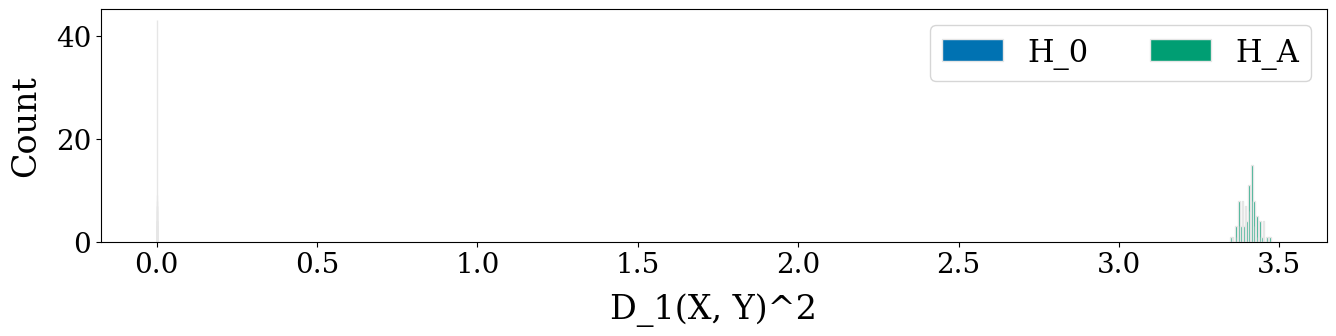

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.hist(MMD_1, bins=25, label='H_0',edgecolor='#E6E6E6')
ax.hist(MMD_2, bins=25, label='H_A',edgecolor='#E6E6E6')

ax.legend(loc='upper right', ncol=2, fontsize=22)
ax.set_xlabel('D_1(X, Y)^2', labelpad=10)
ax.set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()

In [81]:
print(exp_dev_X.shape)
print(exp_dev_Y.shape)

torch.Size([128, 3, 3, 3])
torch.Size([128, 3, 3, 3])


In [82]:
exp_dev_X = exp_dev_X.reshape([-1, 3, 3**2])
exp_dev_Y = exp_dev_Y.reshape([-1, 3, 3**2])

exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag],-1)
exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag],-1)

In [202]:
expected_devx = expected_dev(3, 3)

In [203]:
MMD_1, MMD_2 = expected_devx.train_m_and_M()

start opitmize charateristics function


  0%|          | 0/100 [00:00<?, ?it/s]

Loss updated: 0.00958927907049656
Iteration 0 :  loss = 0.00958927907049656
Loss updated: 0.01289910078048706
Loss updated: 0.013208650052547455
Loss updated: 0.013815561309456825
Loss updated: 0.01783725619316101
Loss updated: 0.025466570630669594
Loss updated: 0.02718450501561165
Loss updated: 0.031856730580329895
Loss updated: 0.03542101010680199
Loss updated: 0.0403374508023262
Loss updated: 0.044821154326200485
Loss updated: 0.04591923579573631
Loss updated: 0.046977076679468155
Loss updated: 0.04904935136437416
Loss updated: 0.049543123692274094
Loss updated: 0.05644277483224869
Loss updated: 0.059887100011110306
Loss updated: 0.060746580362319946
Loss updated: 0.06861215829849243
Loss updated: 0.07545744627714157
Loss updated: 0.08133150637149811
Loss updated: 0.09119126200675964
Loss updated: 0.09300529211759567
Loss updated: 0.09448663145303726
Loss updated: 0.0963139757514
Loss updated: 0.1057518944144249
Loss updated: 0.12693224847316742


No handles with labels found to put in legend.


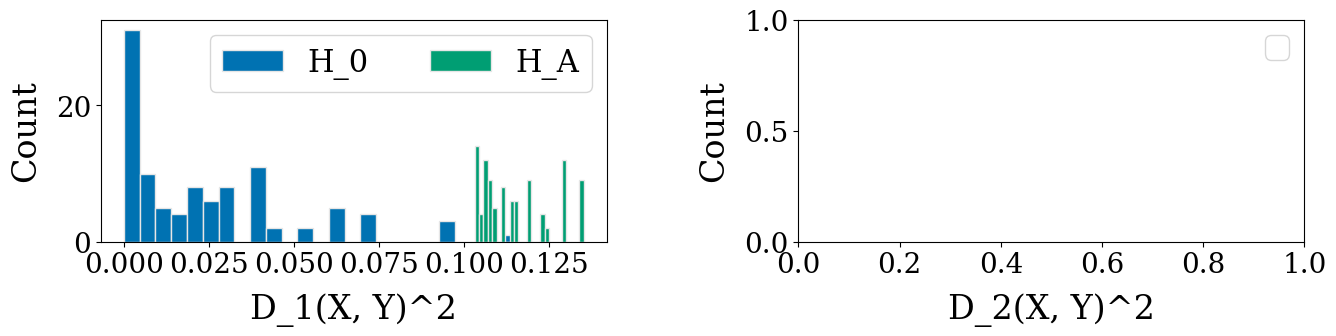

In [204]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(MMD_1, bins=25, label='H_0',edgecolor='#E6E6E6')
ax[0].hist(MMD_2, bins=25, label='H_A',edgecolor='#E6E6E6')

ax[0].legend(loc='upper right', ncol=2, fontsize=22)
ax[0].set_xlabel('D_1(X, Y)^2', labelpad=10)
ax[0].set_ylabel('Count', labelpad=10)

# ax[1].hist(MMD_2, bins=25, label='H_0', edgecolor='#E6E6E6')
# ax[1].hist(MMD_2[:,1], bins=25, label='H_A', edgecolor='#E6E6E6')

ax[1].legend(loc='upper right', ncol=2, fontsize=22)
ax[1].set_xlabel('D_2(X, Y)^2', labelpad=10)
ax[1].set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()

In [134]:
def HS_norm(X: torch.tensor, Y: torch.Tensor):
    """_summary_

    Args:
        X (torch.Tensor): (C,m,m) complexed valued
    """
    if len(X.shape) == 4:

        m = X.shape[-1]
        X = X.reshape(-1, m, m)

    else:
        pass
    D = torch.bmm(X, torch.conj(Y).permute(0, 2, 1))
    return ((torch.einsum('bii->b', D)).mean().real)

### Traing the second pcf

In [33]:
# Training set

list_X, list_Y = compute_true_expected_dev(X[:,:,0,:,:], X_n[:,:,0,:,:], pcf_level_1, x001, xn001, dv_x001, dv_x00_1, dv_xn001, dv_xn00_1)
train_X = list_X[0].reshape([-1, L, lie_degree_1**2]).detach()
train_Y = list_Y[0].reshape([-1, L, lie_degree_1**2]).detach()

train_X_dl = DataLoader(train_X, 128, shuffle=True)
train_Y_dl = DataLoader(train_Y, 128, shuffle=True)

# Test set 
list_X_, list_Y_ = compute_true_expected_dev(X[:,:,1,:,:], X_n[:,:,1,:,:], pcf_level_1, x001, xn001, dv_x001, dv_x00_1, dv_xn001, dv_xn00_1)

In [36]:
def train_pcf(train_X_dl, train_Y_dl, pcf):
    iterations = 1000

    char_optimizer = torch.optim.Adam(
            pcf.parameters(), betas=(0, 0.9), lr=0.002)

    print('start opitmize charateristics function')
    pcf.train()
    for i in tqdm(range(iterations)):
        X_ = next(iter(train_X_dl))
        Y_ = next(iter(train_Y_dl))
        char_optimizer.zero_grad()
        char_loss = - pcf.distance_measure(
                X_, Y_, Lambda=0)
        if i%100 == 0:
            print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
        char_loss.backward()
        char_optimizer.step()
    return pcf

In [37]:
num_samples_2 = 100
lie_degree_2 = 4
pcf_level_2 = char_func_path(num_samples=num_samples_2, 
                              hidden_size=lie_degree_2, 
                              input_dim=lie_degree_1**2, 
                              add_time=add_time, 
                              include_initial = False)
pcf_level_2.to(device)

char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)